# Assignment 1 - Image Deblurring

Name: Michael Senn<br>
Matriculation number: 16-126-880

In [69]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import scipy.signal

from hessian_matrix import hessian_matrix

## Test Image

You can use the following function to create a synthetic image:



(30, 30)


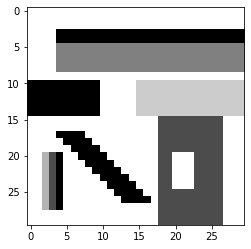

In [27]:
def create_random_binary_img_1():
    # This is going to create an array containing exclusively 1, 
    # so the image is going to be anything but random.
    u = np.random.randint(1,2, 30*30).reshape(30,30).astype(float)
    u[5:9,4:] = 0.5
    u[3:5,4:] = 0
    u[10:15,:10] = 0
    u[10:15,15:] = 0.8
    u[15:, 18:27] = 0.3

    for i in range(10):
        u[i+17,i+4:i+8]  = 0
    
    u[20:25:, 20:23] = 1    
    u[20:28,4] = 0
    u[20:28,3] = 0.3
    u[20:28,2] = 0.7

    return u

sample_image = create_random_binary_img_1()

plt.imshow(sample_image, cmap ="gray")
plt.show()

## hessian_matrix() function

We provide the implementation of the hessian matrix for $k = 0, 1, 2, 3$.

input variables: 
- u: your image
- reg: regularization parameter
- k: one of the four kernel types 0-3 

Example usage:

In [5]:
u_ex = np.zeros(9).reshape(3,3)
reg_ex = 1
k_type_ex = 0 # 16-126-880 mod 4
A = hessian_matrix(u_ex, reg_ex, k_type_ex)
A_n_t = A.toarray()
print(A_n_t)

[[ 4.  -2.   0.  -2.   0.   0.   0.   0.   0. ]
 [-2.   6.  -2.   0.  -2.   0.   0.   0.   0. ]
 [ 0.  -2.   4.   0.   0.  -2.   0.   0.   0. ]
 [-2.   0.   0.   6.5 -1.5  0.  -2.   0.   0. ]
 [ 0.  -2.   0.  -1.5  9.  -1.5  0.  -2.   0. ]
 [ 0.   0.  -2.   0.  -1.5  6.5  0.   0.  -2. ]
 [ 0.   0.   0.  -2.   0.   0.   4.5 -1.5  0. ]
 [ 0.   0.   0.   0.  -2.   0.  -1.5  7.  -1.5]
 [ 0.   0.   0.   0.   0.  -2.   0.  -1.5  4.5]]


## Implementation

In [246]:
def no_regularization(u):
    return np.zeros(u.shape)
    
def anisotropic_regularization(u):
    gradient = np.zeros(u.shape)
    n, m = u.shape
    
    # Case A
    gradient[0, 0] = np.sign(u[0, 0] - u[1, 0]) + np.sign(u[0, 0] - u[0, 1])
    
    # Case B
    gradient[1:n-1, 0] = np.sign(u[1:n-1, 0] - u[0:n-2, 0]) + np.sign(u[1:n-1, 0] - u[2:n, 0]) + np.sign(u[1:n-1, 0] - u[1:n-1, 1])
    
    # Case C
    gradient[n-1, 0] = np.sign(u[n-1, 0] - u[n-2, 0]) + np.sign(u[n-1, 0] - u[n-1, 1])
    
    # Case D
    gradient[n-1, 1:m-1] = np.sign(u[n-1, 1:m-1] - u[n-2, 1:m-1]) + np.sign(u[n-1, 1:m-1] - u[n-1, 0:m-2]) + np.sign(u[n-1, 1:m-1] - u[n-1, 2:m])
    
    # Case E
    gradient[n-1, m-1] = np.sign(u[n-1, m-1] - u[n-2, m-1]) + np.sign(u[n-1, m-1] - u[n-1, m-2])
    
    # Case F
    gradient[1:n-1, m-1] = np.sign(u[1:n-1, m-1] - u[1:n-1, m-2]) + np.sign(u[1:n-1, m-1] - u[2:n, m-1]) + np.sign(u[1:n-1, m-1] - u[0:n-2, m-1])
    
    # Case G
    gradient[0, m-1] = np.sign(u[0, m-1] - u[0, m-2]) + np.sign(u[0, m-1] - u[1, m-1])
    
    # Case H
    gradient[0, 1:m-1] = np.sign(u[0, 1:m-1] - u[1, 1:m-1]) + np.sign(u[0, 1:m-1] - u[0, 2:m]) + np.sign(u[0, 1:m-1] - u[0, 0:m-2])
    
    # Case I
    gradient[1:n-1, 1:m-1] = np.sign(u[1:n-1, 1:m-1] - u[2:n, 1:m-1]) + np.sign(u[1:n-1, 1:m-1] - u[1:n-1, 2:m]) + np.sign(u[1:n-1, 1:m-1] - u[0:n-2, 1:m-1]) + np.sign(u[1:n-1, 1:m-1] - u[1:n-1, 0:m-2])
    
    return gradient

def gaussian_regularization(u):
    gradient = np.zeros(u.shape)
    n, m = u.shape
    
    # Case A
    gradient[0, 0] = 4 * u[0, 0] - 2 * u[1, 0] - 2 * u[0, 1]
    
    # Case B
    gradient[1:n-1, 0] = 6 * u[1:n-1, 0] - 2 * u[0:n-2, 0] - 2 * u[2:n, 0] - 2 * u[1:n-1, 1]
    
    # Case C
    gradient[n-1, 0] = 4 * u[n-1, 0] - 2 * u[n-2, 0] - 2 * u[n-1, 1]
    
    # Case D
    gradient[n-1, 1:m-1] = 6 * u[n-1, 1:m-1] - 2 * u[n-2, 1:m-1] - 2 * u[n-1, 0:m-2] - 2 * u[n-1, 2:m]
    
    # Case E
    gradient[n-1, m-1] = 4 * u[n-1, m-1] - 2 * u[n-2, m-1] - 2 * u[n-1, m-2]
    
    # Case F
    gradient[1:n-1, m-1] = 6 * u[1:n-1, m-1] - 2 * u[1:n-1, m-2] - 2 * u[2:n, m-1] - 2 * u[0:n-2, m-1]
    
    # Case G
    gradient[0, m-1] = 4 * u[0, m-1] - 2 * u[0, m-2] - 2 * u[1, m-1]
    
    # Case H
    gradient[0, 1:m-1] = 6 * u[0, 1:m-1] - 2 * u[1, 1:m-1] - 2 * u[0, 2:m] - 2 * u[0, 0:m-2]
    
    # Case I
    gradient[1:n-1, 1:m-1] = 8 * u[1:n-1, 1:m-1] - 2 * u[2:n, 1:m-1] - 2 * u[1:n-1, 2:m] - 2 * u[0:n-2, 1:m-1] - 2 * u[1:n-1, 0:m-2]
    
    return gradient

def data_term_gradient(u, g):  
    gradient = np.zeros(u.shape)
    n, m = u.shape
    
    # Case A
    gradient[0, 0] = 0
    
    # Case B
    gradient[1:n, 0] = 1/2 * u[1:n, 1] + 1/2 * u[1:n, 0] - g[0:n-1, 0]
    
    # Case C
    gradient[1:n, m-1] = 1/2 * u[1:n, m-2] + 1/2 * u[1:n, m-1] - g[0:n-1, m-2]
    
    # Case D
    gradient[1:n, 1:m-1] = 1/2 * u[1:n, 2:m] + 1/2 * u[1:n, 1:m-1] - g[0:n-1, 1:m-1] + 1/2 * u[1:n, 0:m-2] + 1/2 * u[1:n, 1:m-1] - g[0:n-1, 0:m-2]
    
    return gradient

In [247]:
def GD(g, reg_lambda, reg_term = no_regularization, epsilon = 0.1, stop_criteria = 10**(-1), max_iter = 10**5):
    """
    Gradient Descent algorithm
    g: grayscale blurry image of size (M, N)
    reg_lambda: regularization parameter
    epsilon: Gradient descent learning rate
    stop_criteria: Frobenius norm of gradient below which iteration will stop.
    max_iter: Iteration count after which GD will terminate early.
    """
    
    n, m = g.shape[0], g.shape[1]
    
    # Start with a m+1 x n+1 image initialized to zero
    u = np.zeros((n+1, m+1))
    # And initialize bottom right corner with our original image (this is kernel-specific, 
    # but if done incorrectly will be fixed by GD anyway)
    u[1:n+2, 1:m+2] = g
  
    cur_iter = 0
    while True:
        # Start with GD until convergence, or max_iter reached
        cur_iter += 1
        
        # Gradient of data term
        data_gradient = data_term_gradient(u, g)
        
        # Gradient of data term plus lambda * gradient of chosen regularization term
        gradient = data_gradient + reg_lambda * reg_term(u)
        
        # Froebius norm of full gradient, used as stop condition
        gradient_norm = np.linalg.norm(gradient, ord='fro')
        
        if gradient_norm < stop_criteria:
            print(f"Gradient descent: Stopping after {cur_iter} iterations. Norm of gradient = {gradient_norm}")
            break
            
        if cur_iter > max_iter:
            print(f"WARNING: Gradient descent terminating early after {cur_iter - 1} iterations. Norm of gradient = {gradient_norm}")
            break
                
        # Update rule of GD with step size epsilon
        u = u - epsilon * gradient
            
    return u

In [248]:
def LGS(g, reg_lambda):
    """
    Linearalized Gauss Seidel Algortihm
    g: grayscale blurry image of size (M, N)
    reg_lambda: regularization parameter
    """
    u = g  # TODO: replace with actual implementation
    return u

In [249]:
def LSOR(g, reg_lambda, w):
    """
    Linearized SOR Algorithm
    g: grayscale blyrry image of size (M, N)
    reg_lambda: regularization parameter
    w: SOR parameter
    """
    u = g  # TODO: replace with actual implementation
    return u

### Parameters

In [251]:
reg_lambda = 0.001 # lambda regularization parameter. you need to play with this 
# k matrix. Look below how to choose it 
k = 0 # 16-126-880 mod 0

# reg_term = no_regularization
# reg_term = gaussian_regularization
reg_term = anisotropic_regularization

array([[0., 0.],
       [0., 0.]])

$k =0 \longrightarrow \begin{bmatrix}\frac{1}{2} & \frac{1}{2} \\0&0\end{bmatrix} \hspace{1cm} k =1 \longrightarrow  \begin{bmatrix}\frac{1}{2} & 0 \\\frac{1}{2}&0\end{bmatrix} \hspace{1cm} k =2 \longrightarrow \begin{bmatrix}\frac{1}{2} & 0 \\0&\frac{1}{2}\end{bmatrix}   \hspace{1cm} k =3 \longrightarrow \begin{bmatrix}0 & \frac{1}{2} \\ \frac{1}{2}&0\end{bmatrix}$



### Reading image

You are provided with only the synthetic image. 
The purpose of using a synthetic image is to see possible changes in the deblurred image after applying your algorithm. 
You can convolve the original image using the [scipy library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html).
Note that you must choose **valid** as the mode in your convolution.

In [252]:
img_org = sample_image = create_random_binary_img_1()

kernel = np.array([[1/2, 1/2], [0, 0]])

# 'valid' mode will not do any padding, and rather simply 
# discard the pixels for which there would be out-of-bounds issues.
img_blurred = scipy.signal.convolve2d(sample_image, kernel, mode='valid')


## GRADIENT DESCENT

In [253]:
def loss_term(reconstructed_img, blurry_img):
    # Loss term as per equation 3 of PDF
    
    # First re-blur the reconstructed image
    reblurred_img = scipy.signal.convolve2d(reconstructed_img, kernel, mode='valid')
    
    # Loss term is now sum of absolute (per-pixel) differences
    return np.absolute(reblurred_img - blurry_img).sum()

def sse(reconstructed_img, original_img):
    """Calculate sum of squared (element-wise) differences"""
    
    return np.square(reconstructed_img - original_img).sum()

Running gradient descent with convergence criteria = 0.01, step size = 0.1
Regularization term: <function anisotropic_regularization at 0x7f2bdc6404c0> with lambda = 0.001
(29, 29)
(30, 30)
(30, 30)


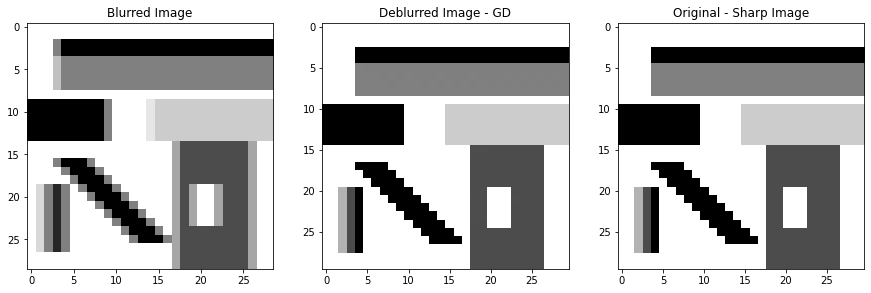

For lambda 0.00100	 
k_type 0
Loss Data Term = 0.29108205903774353
Sum of Squared Distance: deblurred vs. original = 0.0006037885214978733


In [255]:
gd_epsilon = 0.1
gd_stop_criteria = 10**(-2)

print(f"Running gradient descent with convergence criteria = {gd_stop_criteria}, step size = {gd_epsilon}")
print(f"Regularization term: {reg_term} with lambda = {reg_lambda}")
# run gradient descent algorithm
img_deblurred_gd = GD(img_blurred, reg_lambda, reg_term=reg_term, epsilon=gd_epsilon, stop_criteria=gd_stop_criteria)


print(img_blurred.shape)
print(img_deblurred_gd.shape)
print(img_org.shape)
# for visualization purpose 
# img_deblurred_gd = np.clip(u_final_gd, 0, 1)


plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_gd, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org, cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - GD")
ax3.set_title("Original - Sharp Image")
plt.show()

print(f"For lambda {reg_lambda:.5f}\t \nk_type {k:1d}")

# TODO: print the loss
print(f"Loss Data Term = {loss_term(img_deblurred_gd, img_blurred)}")

# TODO: print the error
print(f"Sum of Squared Distance: deblurred vs. original = {sse(img_deblurred_gd, img_org)}")  

## SOR

In [ ]:
w = 0.3 #play with this

# run LSOR algorithm
img_deblurred_sor = LSOR(img_blurred, reg_lambda, w)


plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_sor, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org,cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - LSOR")
ax3.set_title("Original - Sharp Image")
#plt.savefig("results_"+str(k)+".png")
plt.show()

print(f"For lambda {reg_lambda:.5f}")

# TODO: print the loss
print(f"Loss Data Term = ")

# TODO: print the error
print("Sum of Squared Distance: deblurred vs. original = ")  

## GAUSS - SEIDEL

In [ ]:
nb_iter = 1

# run LGS algorithm
img_deblurred_gs = LGS(img_blurred, reg_lambda)


plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_gs, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org, cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - LGS")
ax3.set_title("Original - Sharp Image")
plt.show()

print(f"For lambda {reg_lambda:.5f}")

# TODO: print the loss
print(f"Loss Data Term = ")

# TODO: print the error
print("Sum of Squared Distance: deblurred vs. original = ")  